# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

## Предположения:
    1. Сотрудники с большей средней зарплатой дольше работают в компании
    2. Есть зависимость между рассой и оценкой производиетльности.
    3. Есть зависимость между зарплатой и проиводительностью.
    4. Есть зависимость между зарплатой сотрудника в час и средней стоимостью рекрутинга

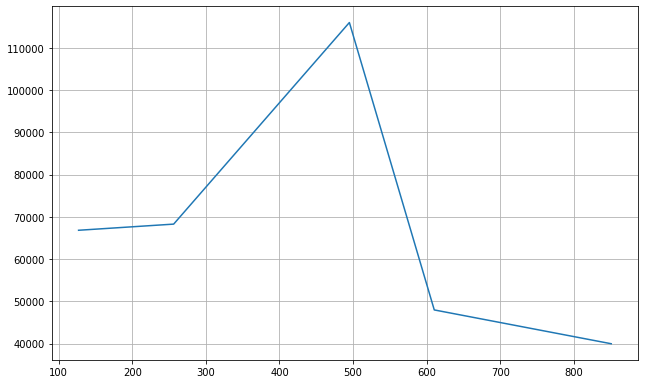

In [15]:
# Сотрудники с большей средней зарплатой дольше работают в компании
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port":5432,
    "dbname":"human_resources",
    "user":"readonly",
    "password":"6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection);

cursor = conn.cursor()

df = pd.read_sql_query("""SELECT AVG(hr_dataset."Days Employed") AS days_employed,
                            salary_grid."Salary Mid" AS salary_mid
                            FROM hr_dataset LEFT JOIN salary_grid ON hr_dataset.position=salary_grid."Position" 
                            WHERE hr_dataset."Date of Termination" is not null GROUP BY salary_mid""", conn)



conn.commit();


df.dropna()
df= df.sort_values(by='days_employed');

fig, subplot = plt.subplots()
fig.set_size_inches(10.5,6.5 , forward=True)
subplot.grid()
subplot.plot(df['days_employed'], df['salary_mid'])

1. В некотормо смысле получилась обратная картина. Люди на должностях с высокой средней оплатой работают в среднем меньше (до момента увольнения) чем люди с более высокой оплатой. Возможно более дорогие и востребованные специалисты не находят в данной компании места для карьерного роста и развития. Стоит разработать тест и провести анкетирование среди таких специалистов, чтобы попытаться выяснить причины. 

In [25]:
#Есть зависимость между рассой и оценкой производиетльности.
df = pd.read_sql_query("""SELECT production_staff."Race Desc" as race, 
                            SUM(CASE 
                                WHEN production_staff."Performance Score" = 'Fully Meets' 
                                    THEN 1 
                                    ELSE 0 
                            END) as fully_meets,
                            SUM(CASE 
                                WHEN production_staff."Performance Score" = 'Exceptional' 
                                    THEN 1
                                    ELSE 0 
                            END) as exceptional,
                            SUM(CASE
                                WHEN production_staff."Performance Score" = '90-day meets'
                                    THEN 1
                                    ELSE 0
                            END) as ninety_day_meets,
                            SUM(CASE
                                WHEN production_staff."Performance Score" = 'N/A- too early to review'
                                    THEN 1
                                    ELSE 0
                            END) as too_early,
                            SUM(CASE
                                WHEN production_staff."Performance Score" = 'Needs Improvement'
                                    THEN 1
                                    ELSE 0
                            END) as needs_improvement,
                            SUM(CASE
                                WHEN production_staff."Performance Score" = 'Exceeds'
                                    THEN 1
                                    ELSE 0
                            END) as exceeds,
                            SUM(CASE
                                WHEN production_staff."Performance Score" = 'PIP'
                                    THEN 1
                                    ELSE 0
                            END) as pip,
                            COUNT(production_staff."Race Desc")
                       FROM production_staff GROUP BY  race""", conn)

conn.commit()

df = df.dropna()

df

,race,fully_meets,exceptional,ninety_day_meets,too_early,needs_improvement,exceeds,pip,count
1,Hispanic,2,0,0,1,0,0,0,3
2,Asian,14,0,2,2,1,2,1,22
3,White,80,3,14,19,5,15,4,140
4,Black or African American,20,1,1,2,5,1,1,31
5,American Indian or Alaska Native,1,0,0,0,0,2,0,3
6,Two or more races,5,0,1,1,0,2,1,10


2. Никакой явной зависимости между рассой и оценкой производиельности не наблюдается.

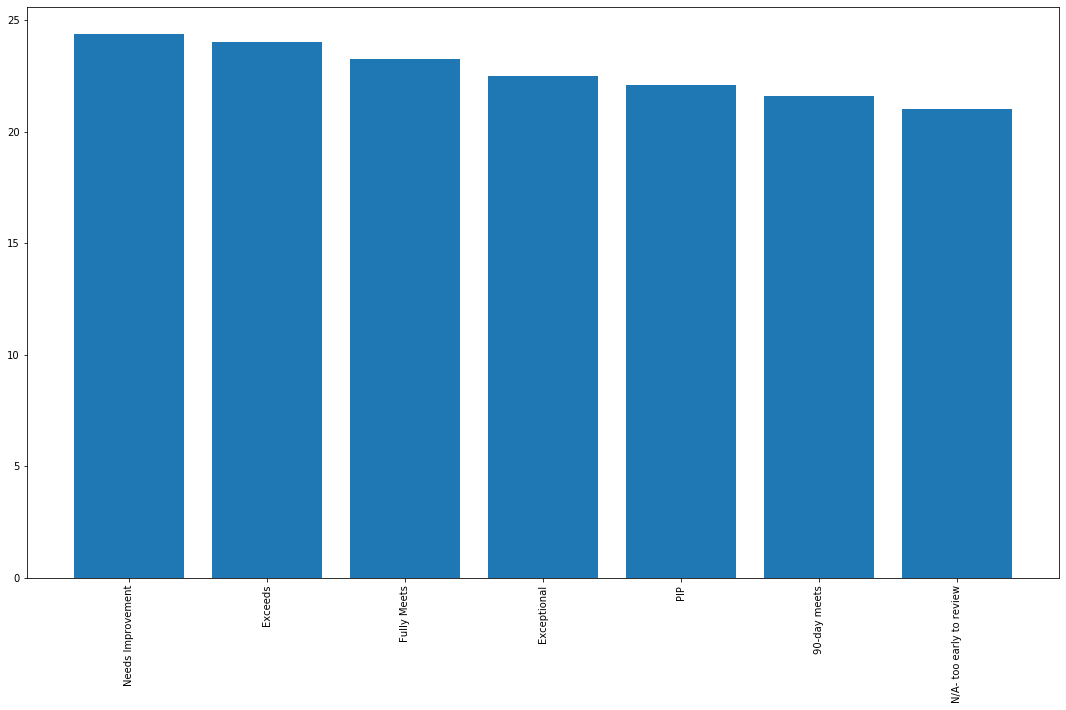

In [48]:
#Есть зависимость между зарплатой и проиводительностью.
import matplotlib.pyplot as plt

df = pd.read_sql_query(""" SELECT AVG(RIGHT(production_staff."Pay"::varchar,5)::float) as pay,
                            production_staff."Performance Score" as performance_score 
                            FROM production_staff GROUP BY performance_score """, conn)

conn.commit()
df = df.dropna()

df = df.sort_values(by='pay', ascending=False)

fig, subplot = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)

subplot.bar(df['performance_score'],
          df['pay']) 

plt.xticks(rotation=90)
plt.show()

3. Средняя зарплата чуть выше у сотрудников квалфикация которых требует улучшения, на тертьем месте. Стоит обратить внимание на систему оплаты труда. Возможно компания переплачивает тем кому можно платитьм еньше и недоплачивает тем кому следует.

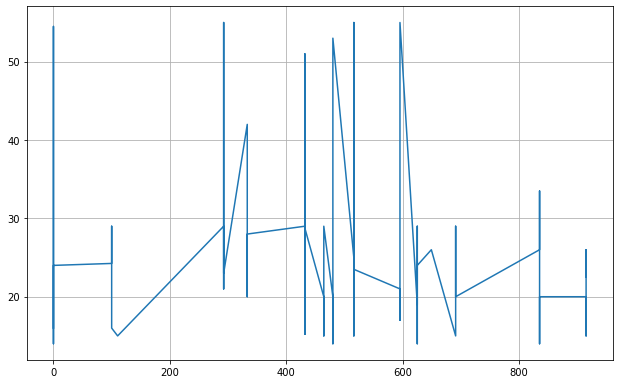

In [22]:
#Есть зависимость между зарплатой сотрудника в час и средней стоимостью рекрутинга
import matplotlib.pyplot as plt

df = pd.read_sql_query("""SELECT hr_dataset."Employee Name", hr_dataset."Employee Source", RIGHT(production_staff."Pay"::varchar,5)::float as pay,
                            production_staff."Performance Score" as performance_score, recruiting_costs."Total"/12::float as cost
                            FROM hr_dataset LEFT JOIN production_staff 
                                ON hr_dataset."Employee Name"=production_staff."Employee Name" 
                            LEFT JOIN recruiting_costs 
                                ON hr_dataset."Employee Source" = recruiting_costs."Employment Source"  """, conn)
df = df.dropna()
df = df.sort_values(by='cost', ascending=True)

#f= df.sort_values(by='days_employed');

fig, subplot = plt.subplots()
fig.set_size_inches(10.5,6.5 , forward=True)
subplot.grid()
subplot.plot(df['cost'], df['pay'])
#df

4. Зависимости между зарплатой сотрудника в час и средней стоимостью рекрутинга нет. 

In [3]:
import psycopg2
import pandas as pd

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port":5432,
    "dbname":"human_resources",
    "user":"readonly",
    "password":"6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection);

cursor = conn.cursor()

df_hr = pd.read_sql_query("SELECT * FROM hr_dataset", conn)

df_prod = pd.read_sql_query("SELECT * FROM production_staff", conn)

df_recr = pd.read_sql_query("SELECT * FROM recruiting_costs", conn)

df_salary = pd.read_sql_query("SELECT * FROM salary_grid", conn)
  
#sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
#cursor.execute(sql_str)
#tables_data = [a for a in cursor.fetchall()]
conn.commit()

#print("Какие таблицы содержатся в Postgres: %s" % tables_data)


conn.commit()

#df_prod = df_prod[df_prod['Department']!='Production']
df_hr
#df_prod.sort_values(by='Employee Name')
#df_recr
#print(df_prod.head())
#print(df_recr.head())
#df_salary

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review
5,6,"Smith, Leigh Ann",711007713,1,1,0,5,1,3,30,...,2011-09-26,730,2013-09-25,career change,Voluntarily Terminated,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
6,7,"LeBlanc, Brandon R",1102024115,1,1,1,1,1,3,33,...,2016-01-05,691,None,N/A - still employed,Active,Admin Offices,Shared Services Manager,Janet King,Monster.com,Fully Meets
7,8,"Quinn, Sean",1206043417,1,1,1,5,1,3,33,...,2011-02-21,1636,2015-08-15,career change,Voluntarily Terminated,Admin Offices,Shared Services Manager,Janet King,Diversity Job Fair,Fully Meets
8,9,"Boutwell, Bonalyn",1307060188,1,1,0,1,1,0,31,...,2015-02-16,1014,None,N/A - still employed,Active,Admin Offices,Sr. Accountant,Brandon R. LeBlanc,Diversity Job Fair,90-day meets
9,10,"Foster-Baker, Amy",1201031308,1,1,0,1,1,3,39,...,2009-01-05,3247,None,N/A - still employed,Active,Admin Offices,Sr. Accountant,Board of Directors,Other,Fully Meets


## Часть вторая

In [40]:
df_hr.sort_values(by='Employee Name')

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
67,68,"Adinolfi, Wilson K",1409070522,0,0,1,1,5,4,34,...,2011-07-05,2336,None,N/A - still employed,Active,Production,Production Technician I,Michael Albert,MBTA ads,Exceeds
43,44,"Ait Sidi, Karthikeyan",1307060199,1,1,1,5,3,3,43,...,2015-03-30,444,2016-06-16,career change,Voluntarily Terminated,IT/IS,Sr. DBA,Simon Roup,Company Intranet - Partner,Fully Meets
203,204,"Akinkuolie, Sarah",1005019209,1,1,0,5,5,0,29,...,2011-07-05,447,2012-09-24,hours,Voluntarily Terminated,Production,Production Technician II,Kissy Sullivan,Newspager/Magazine,90-day meets
68,69,"Alagbe,Trina",1011022883,1,1,0,1,5,3,29,...,2008-01-07,3611,None,N/A - still employed,Active,Production,Production Technician I,Elijiah Gray,Billboard,Fully Meets
53,54,"Albert, Michael",1501072311,0,2,1,1,5,3,49,...,2011-08-01,2309,None,N/A - still employed,Active,Production,Production Manager,Janet King,Employee Referral,Fully Meets
69,70,"Anderson, Carol",1001417624,0,2,0,5,5,9,28,...,2011-07-11,57,2011-09-06,return to school,Voluntarily Terminated,Production,Production Technician I,Webster Butler,Word of Mouth,N/A- too early to review
70,71,"Anderson, Linda",1304055947,0,0,0,1,5,5,41,...,2012-01-09,2148,None,N/A - still employed,Active,Production,Production Technician I,Amy Dunn,MBTA ads,Exceptional
291,292,"Andreola, Colby",1107027358,0,0,0,1,4,3,39,...,2014-11-10,1112,None,N/A - still employed,Active,Software Engineering,Software Engineer,Alex Sweetwater,Vendor Referral,Fully Meets
71,72,"Athwal, Sam",1301052124,0,4,1,1,5,9,35,...,2013-09-30,1518,None,N/A - still employed,Active,Production,Production Technician I,Ketsia Liebig,Employee Referral,N/A- too early to review
72,73,"Bachiochi, Linda",1212051409,0,0,0,3,5,3,48,...,2009-07-06,3065,None,N/A - still employed,Leave of Absence,Production,Production Technician I,Brannon Miller,Diversity Job Fair,Fully Meets


Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [134]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import re

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

vk_token = "592a8b6b7b2ab7dbff9b58575fec88366f7bca1b85b9e2d263bd8c4f4209f4fe259e3127b4e8179668e61"

url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=100&v=5.92'
response = getjson(url)

list_result = response['response']['items'] 

date = list_result[0]['date']
dt = datetime.fromtimestamp(date) - timedelta(hours=0)

start_date = dt 

date = list_result[99]['date']
dt = datetime.fromtimestamp(date) - timedelta(hours=0)

finish_date = dt 

offset=100
while((start_date-finish_date)<=timedelta(days=365)):
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset='+str(offset)+'&count=100&v=5.92'
    response = getjson(url)
    list_result+= response['response']['items']
    date = list_result[offset+99]['date']
    dt = datetime.fromtimestamp(date) - timedelta(hours=0)
    finish_date = dt
    offset+=100;

df = pd.DataFrame(list_result)

reg_expr = r'#\w+'
reg_expr_compiled = re.compile(reg_expr)

df['tags'] = df['text'].apply(lambda x: reg_expr_compiled.findall(x))
df['comments_count'] = df['comments'].apply(lambda x:  x['count'])
df['likes_count'] = df['likes'].apply(lambda x:  x['count'])
df['reposts_count'] = df['reposts'].apply(lambda x:  x['count'])
df['views_count'] = df['views'].apply(lambda x:  x['count'])
df['date']=df['date'].apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)))

df['date_full']= df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
df['time']= df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')[11:-6])
df['time']=df['time'].astype(int)

df


,attachments,comments,copy_history,date,from_id,id,is_favorite,likes,marked_as_ads,owner_id,...,reposts,text,views,tags,comments_count,likes_count,reposts_count,views_count,date_full,time
0,"[{'type': 'photo', 'photo': {'id': 457494478, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-23 16:10:20,-66669811,47817,False,"{'count': 13, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 0, 'user_reposted': 0}",Онлайн-платформа Readymag эффектно подвела ито...,{'count': 5379},"[#Взакладки_Skillbox, #Тренды, #Skillbохдизайн]",0,13,0,5379,2019-12-23 16:10:20,16
1,"[{'type': 'photo', 'photo': {'id': 457494472, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-23 14:02:19,-66669811,47815,False,"{'count': 7, 'user_likes': 0, 'can_like': 1, '...",0,-66669811,...,"{'count': 0, 'user_reposted': 0}","Новый год уже на следующей неделе, но это не п...",{'count': 5207},[#Расписание_Skillbox],0,7,0,5207,2019-12-23 14:02:19,14
2,"[{'type': 'photo', 'photo': {'id': 457494438, ...","{'count': 3, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-22 11:15:24,-66669811,47768,False,"{'count': 112, 'user_likes': 0, 'can_like': 1,...",0,-66669811,...,"{'count': 26, 'user_reposted': 0}",Что будет в трендах 2020 года? Видеоконференци...,{'count': 20879},"[#FF4500, #7FFFD4, #191970, #В_закладки_Skillb...",3,112,26,20879,2019-12-22 11:15:24,11
3,"[{'type': 'photo', 'photo': {'id': 457494381, ...","{'count': 21, 'can_post': 1, 'groups_can_post'...",NaN,2019-12-21 11:05:11,-66669811,47553,False,"{'count': 24, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 5, 'user_reposted': 0}","В этот день, 106 лет назад, в американской газ...",{'count': 11517},"[#Skillbox_маркетинг, #Конкурс_Skillbox]",21,24,5,11517,2019-12-21 11:05:11,11
4,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 6, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-20 18:16:35,-66669811,47437,False,"{'count': 18, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 0, 'user_reposted': 0}",Где искать идеи для стартапа? Возможно ли запу...,{'count': 10666},[#Статья_Skillbox],6,18,0,10666,2019-12-20 18:16:35,18
5,"[{'type': 'photo', 'photo': {'id': 457494336, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-20 12:15:19,-66669811,47405,False,"{'count': 72, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 7, 'user_reposted': 0}",Новости про бурное развитие нейросетей невольн...,{'count': 17904},"[#Skillbox_программирование, #В_закладки_Skill...",0,72,7,17904,2019-12-20 12:15:19,12
6,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-19 19:05:19,-66669811,47216,False,"{'count': 44, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 6, 'user_reposted': 0}",Как правильно реагировать на оскорбления? Обид...,{'count': 11065},"[#Статья_Skillbox, #Skillbox_дизайн]",0,44,6,11065,2019-12-19 19:05:19,19
7,"[{'type': 'photo', 'photo': {'id': 457494287, ...","{'count': 30, 'can_post': 1, 'groups_can_post'...",NaN,2019-12-19 12:15:12,-66669811,47079,False,"{'count': 15, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 0, 'user_reposted': 0}",Новый год — время перемен. А вот Тинькофф не с...,{'count': 16059},"[#Design_Battle_Skillbox, #Skillbox_дизайн]",30,15,0,16059,2019-12-19 12:15:12,12
8,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 4, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-18 18:35:42,-66669811,47064,False,"{'count': 83, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,"{'count': 12, 'user_reposted': 0}",Блокчейн — звучит как название боевика 90-х. Ч...,{'count': 14147},"[#Статья_Skillbox, #Skillbox_программирование]",4,83,12,14147,2019-12-18 18:35:42,18
9,"[{'type': 'video', 'video': {'id': 456239749, ...","{'count': 2, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-18 14:19:59,-66669811,47048,False,"{'count': 37, 'user_likes': 0, 'can_like': 1, ...",0,-6666

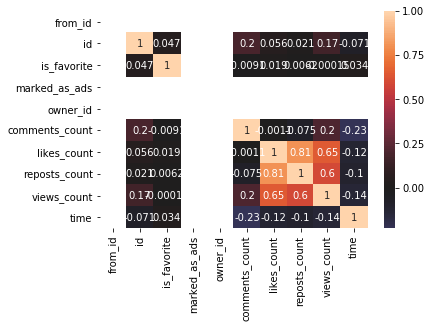

In [135]:
sns.heatmap(df.corr(), center=0, annot=True)

In [154]:
df['tags_count'] = df['tags'].apply(lambda x: len(x))
df['tags_count'].max()
for i in range(6):
    df['tag_'+str(i)]=df['tags'].apply(lambda x: None if i>=len(x) else x[i])

df

,attachments,comments,copy_history,date,from_id,id,is_favorite,likes,marked_as_ads,owner_id,...,views_count,date_full,time,tags_count,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5
0,"[{'type': 'photo', 'photo': {'id': 457494478, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-23 16:10:20,-66669811,47817,False,"{'count': 13, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,5379,2019-12-23 16:10:20,16,3,#Взакладки_Skillbox,#Тренды,#Skillbохдизайн,None,None,None
1,"[{'type': 'photo', 'photo': {'id': 457494472, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-23 14:02:19,-66669811,47815,False,"{'count': 7, 'user_likes': 0, 'can_like': 1, '...",0,-66669811,...,5207,2019-12-23 14:02:19,14,1,#Расписание_Skillbox,None,None,None,None,None
2,"[{'type': 'photo', 'photo': {'id': 457494438, ...","{'count': 3, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-22 11:15:24,-66669811,47768,False,"{'count': 112, 'user_likes': 0, 'can_like': 1,...",0,-66669811,...,20879,2019-12-22 11:15:24,11,6,#FF4500,#7FFFD4,#191970,#В_закладки_Skillbox,#Тренды,#Skillbox_дизайн
3,"[{'type': 'photo', 'photo': {'id': 457494381, ...","{'count': 21, 'can_post': 1, 'groups_can_post'...",NaN,2019-12-21 11:05:11,-66669811,47553,False,"{'count': 24, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,11517,2019-12-21 11:05:11,11,2,#Skillbox_маркетинг,#Конкурс_Skillbox,None,None,None,None
4,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 6, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-20 18:16:35,-66669811,47437,False,"{'count': 18, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,10666,2019-12-20 18:16:35,18,1,#Статья_Skillbox,None,None,None,None,None
5,"[{'type': 'photo', 'photo': {'id': 457494336, ...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-20 12:15:19,-66669811,47405,False,"{'count': 72, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,17904,2019-12-20 12:15:19,12,2,#Skillbox_программирование,#В_закладки_Skillbox,None,None,None,None
6,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 0, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-19 19:05:19,-66669811,47216,False,"{'count': 44, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,11065,2019-12-19 19:05:19,19,2,#Статья_Skillbox,#Skillbox_дизайн,None,None,None,None
7,"[{'type': 'photo', 'photo': {'id': 457494287, ...","{'count': 30, 'can_post': 1, 'groups_can_post'...",NaN,2019-12-19 12:15:12,-66669811,47079,False,"{'count': 15, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,16059,2019-12-19 12:15:12,12,2,#Design_Battle_Skillbox,#Skillbox_дизайн,None,None,None,None
8,"[{'type': 'link', 'link': {'url': 'https://ski...","{'count': 4, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-18 18:35:42,-66669811,47064,False,"{'count': 83, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,14147,2019-12-18 18:35:42,18,2,#Статья_Skillbox,#Skillbox_программирование,None,None,None,None
9,"[{'type': 'video', 'video': {'id': 456239749, ...","{'count': 2, 'can_post': 1, 'groups_can_post':...",NaN,2019-12-18 14:19:59,-66669811,47048,False,"{'count': 37, 'user_likes': 0, 'can_like': 1, ...",0,-66669811,...,12571,2019-12-18 14:19:59,14,2,#Skillbox_дизайн,#Skillbox_вдохновляет,None,None,None,None


In [157]:
tags_list=[]
for tag in df['tags'].values:
    tags_list+=tag;

tags_dict = set(tags_list)

for tag in tags_dict:
    for line in df:
        if(tag in line['tags']):
            df_1.append(line)
            

    

TypeError: string indices must be integers